In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import torch
from data_parser import data_loader_full
import io
from matplotlib import cm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

file_path = 'Model_first_order/Predicted/results.pkl'
with open(file_path, 'rb') as pickle_file:
    pred = CPU_Unpickler(pickle_file).load()

In [3]:
data_occupancy_all, data_flow_all, data_speed_all = data_loader_full()
X_occu_all, y_occu_all = data_occupancy_all[:, :2], data_occupancy_all[:, 2]
X_occu_all, y_occu_all = torch.tensor(X_occu_all, dtype=torch.float32, requires_grad=True), torch.tensor(y_occu_all, dtype=torch.float32).unsqueeze(1)

In [4]:
pred_occu = pred['occupancy_recon'].to(torch.device('cpu'))
pred_flow = pred['flow_recon'].to(torch.device('cpu'))
pred_speed = pred['speed_recon'].to(torch.device('cpu'))

pred_k_t = pred['k_t'].to(torch.device('cpu'))
pred_k_t_predict = pred['k_t_predict'].to(torch.device('cpu'))

In [5]:
occupancy_recon = torch.cat((X_occu_all, pred_occu), dim=1).detach().numpy()
flow_recon = torch.cat((X_occu_all, pred_flow), dim=1).detach().numpy()
speed_recon = torch.cat((X_occu_all, pred_speed), dim=1).detach().numpy()
k_t = torch.cat((X_occu_all, pred_k_t), dim=1).detach().numpy()
k_t_predict = torch.cat((X_occu_all, pred_k_t_predict), dim=1).detach().numpy()

In [6]:
occupancy_recon = pd.DataFrame(occupancy_recon, columns = ['TimeStep','Station_Number','Occupancy'])
flow_recon = pd.DataFrame(flow_recon, columns = ['TimeStep','Station_Number','Flow'])
speed_recon = pd.DataFrame(speed_recon, columns = ['TimeStep','Station_Number','Speed'])

k_t = pd.DataFrame(k_t, columns = ['TimeStep','Station_Number','k_t'])
k_t_predict = pd.DataFrame(k_t_predict, columns=['TimeStep', 'Station_Number', 'k_t'])

In [7]:
occupancy_recon['TimeStep'] = occupancy_recon['TimeStep'].astype(int)
occupancy_recon['Station_Number'] = occupancy_recon['Station_Number'].astype(int)
flow_recon['TimeStep'] = flow_recon['TimeStep'].astype(int)
flow_recon['Station_Number'] = flow_recon['Station_Number'].astype(int)
speed_recon['TimeStep'] = speed_recon['TimeStep'].astype(int)
speed_recon['Station_Number'] = speed_recon['Station_Number'].astype(int)

occupancy_recon_wide = occupancy_recon.pivot(index='Station_Number', columns='TimeStep', values='Occupancy')
flow_recon_wide = flow_recon.pivot(index='Station_Number', columns='TimeStep', values='Flow')
speed_recon_wide = speed_recon.pivot(index='Station_Number', columns='TimeStep', values='Speed')

In [8]:
# Load True Traffic data
Flow = pd.read_csv('Data_Clean/Flow_all.csv',index_col='Station_PM')
Occupancy = pd.read_csv('Data_Clean/Occupancy_all.csv',index_col='Station_PM')
Speed = pd.read_csv('Data_Clean/Speed_all.csv',index_col='Station_PM')

# Select the first 288 timestep
Occupancy = 100*Occupancy.iloc[:,72:216]
Flow = Flow.iloc[:,72:216]
Speed = Speed.iloc[:,72:216]

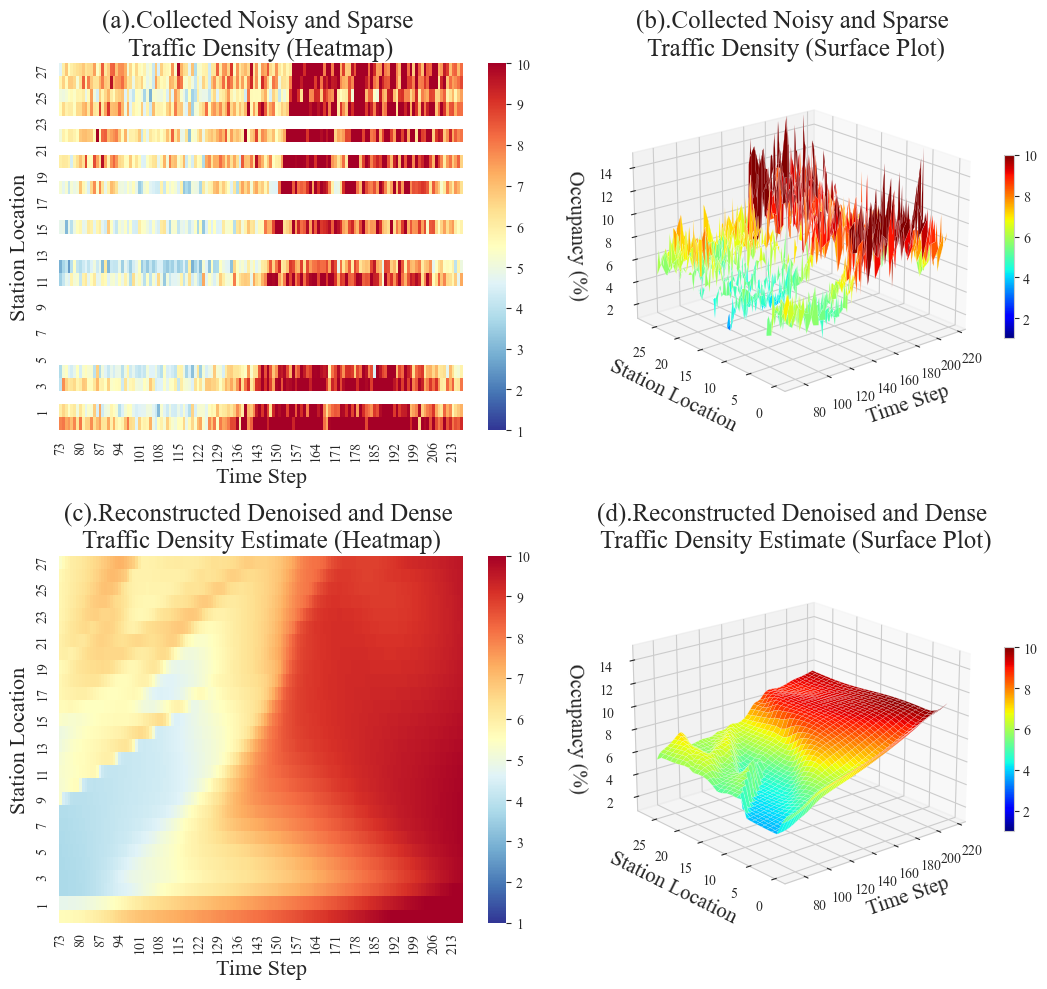

In [9]:
# Occupancy Reconstruction
fig = plt.figure(figsize=(11, 10))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 15
low_lim = 1
norm = plt.Normalize(1, 10)

loc, time = occupancy_recon_wide.index.values, occupancy_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
occu_values = occupancy_recon_wide.values.T
occu_ori = Occupancy.values.T

ax1 = fig.add_subplot(222, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 15)
ax1.set_ylabel('Station Location', fontsize = 15)
ax1.set_zlabel('Occupancy (%)', fontsize = 15)
ax1.set_title('(b).Collected Noisy and Sparse \nTraffic Density (Surface Plot)', fontsize = 18)

ax2 = fig.add_subplot(224, projection='3d')
surf2 = ax2.plot_surface(time, loc, occu_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax2.set_zlim(low_lim, up_lim)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 15)
ax2.set_ylabel('Station Location', fontsize = 15)
ax2.set_zlabel('Occupancy (%)', fontsize = 15)
ax2.set_title('(d).Reconstructed Denoised and Dense \nTraffic Density Estimate (Surface Plot)', fontsize = 18)

vmin1_occu, vmax1_occu = 1, 10

ax3 = fig.add_subplot(221)
sns.heatmap(Occupancy.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax3)
ax3.set_ylabel('Station Location', fontsize = 16)
ax3.set_xlabel('Time Step',  fontsize = 16)
ax3.set_title("(a).Collected Noisy and Sparse \nTraffic Density (Heatmap)",  fontsize = 18)


ax4 = fig.add_subplot(223)
sns.heatmap(occupancy_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax4)
ax4.set_ylabel('Station Location', fontsize = 16)
ax4.set_xlabel('Time Step',  fontsize = 16)
ax4.set_title("(c).Reconstructed Denoised and Dense \nTraffic Density Estimate (Heatmap)",  fontsize = 18)

fig.colorbar(surf1, ax=ax1, shrink=0.5)
fig.colorbar(surf2, ax=ax2, shrink=0.5)
plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/Reconstruction/Occupancy_2D_3D.png",bbox_inches='tight', dpi = 300)

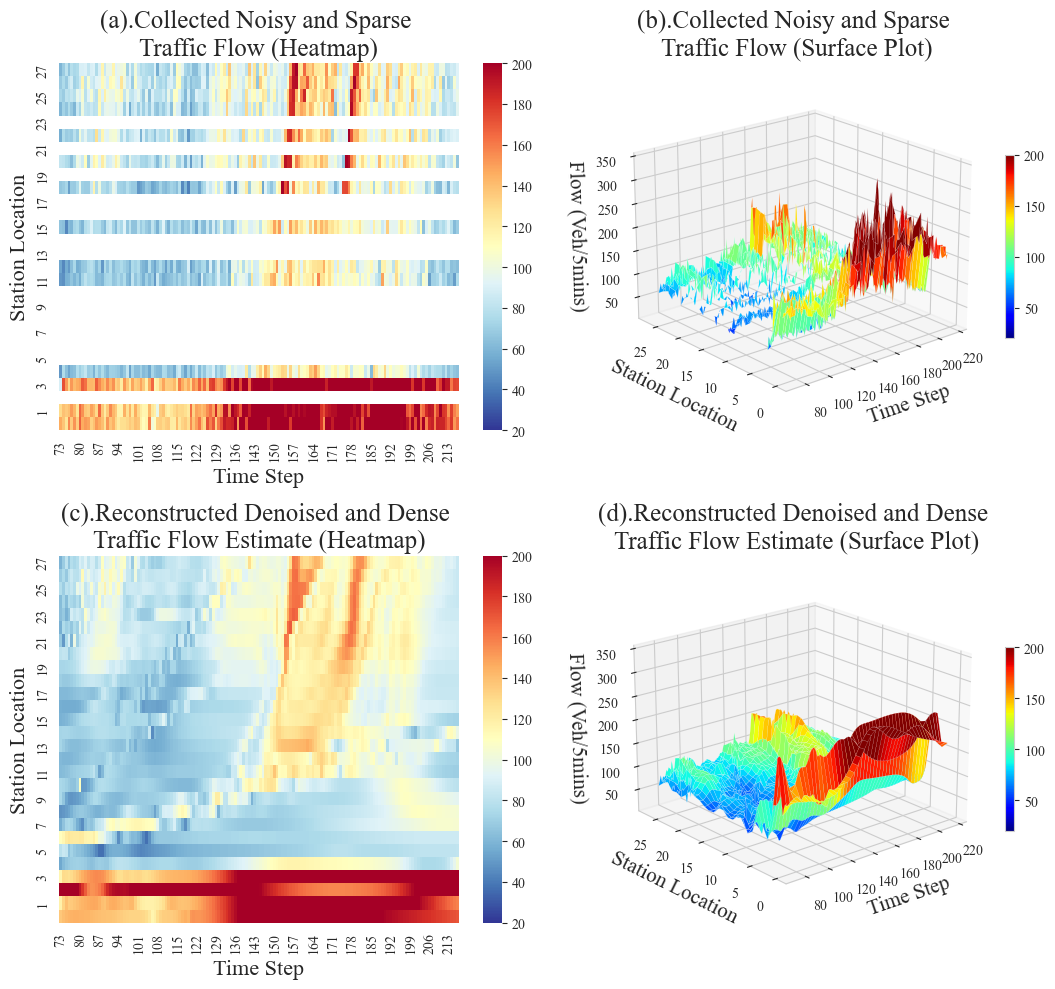

In [10]:
# Flow Reconstruction
fig = plt.figure(figsize=(11, 10))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 350
low_lim = 10
norm = plt.Normalize(20, 200)

loc, time = flow_recon_wide.index.values, flow_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
flow_values = flow_recon_wide.values.T
flow_ori = Flow.values.T

ax1 = fig.add_subplot(222, projection='3d')
surf1 = ax1.plot_surface(time, loc, flow_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 15)
ax1.set_ylabel('Station Location', fontsize = 15)
ax1.set_zlabel('Flow (Veh/5mins)', fontsize = 15)
ax1.set_title('(b).Collected Noisy and Sparse \nTraffic Flow (Surface Plot)', fontsize = 18)

ax2 = fig.add_subplot(224, projection='3d')
surf2 = ax2.plot_surface(time, loc, flow_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax2.set_zlim(low_lim, up_lim)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 15)
ax2.set_ylabel('Station Location', fontsize = 15)
ax2.set_zlabel('Flow (Veh/5mins)', fontsize = 15)
ax2.set_title('(d).Reconstructed Denoised and Dense \nTraffic Flow Estimate (Surface Plot)', fontsize = 18)

vmin1_occu, vmax1_occu = 20, 200

ax3 = fig.add_subplot(221)
sns.heatmap(Flow.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax3)
ax3.set_ylabel('Station Location', fontsize = 16)
ax3.set_xlabel('Time Step',  fontsize = 16)
ax3.set_title("(a).Collected Noisy and Sparse \nTraffic Flow (Heatmap)",  fontsize = 18)


ax4 = fig.add_subplot(223)
sns.heatmap(flow_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax4)
ax4.set_ylabel('Station Location', fontsize = 16)
ax4.set_xlabel('Time Step',  fontsize = 16)
ax4.set_title("(c).Reconstructed Denoised and Dense \nTraffic Flow Estimate (Heatmap)",  fontsize = 18)

fig.colorbar(surf1, ax=ax1, shrink=0.5)
fig.colorbar(surf2, ax=ax2, shrink=0.5)
plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/Reconstruction/Flow_2D_3D.png",bbox_inches='tight', dpi = 300)

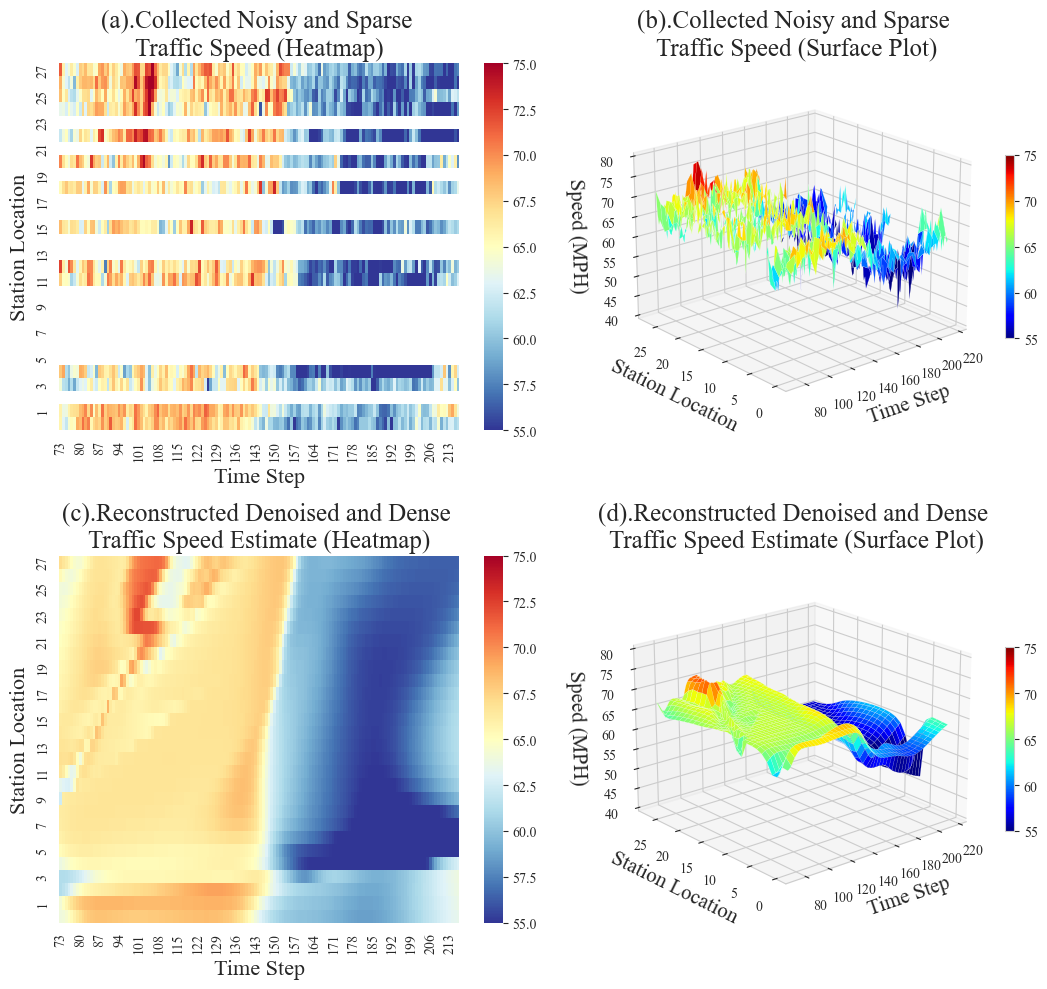

In [11]:
# Speed Reconstruction
fig = plt.figure(figsize=(11, 10))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim = 80
low_lim = 40
norm = plt.Normalize(55, 75)

loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T
speed_ori = Speed.values.T

ax1 = fig.add_subplot(222, projection='3d')
surf1 = ax1.plot_surface(time, loc, speed_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax1.set_zlim(low_lim, up_lim)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 15)
ax1.set_ylabel('Station Location', fontsize = 15)
ax1.set_zlabel('Speed (MPH)', fontsize = 15)
ax1.set_title('(b).Collected Noisy and Sparse \nTraffic Speed (Surface Plot)', fontsize = 18)

ax2 = fig.add_subplot(224, projection='3d')
surf2 = ax2.plot_surface(time, loc, speed_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm)
ax2.set_zlim(low_lim, up_lim)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 15)
ax2.set_ylabel('Station Location', fontsize = 15)
ax2.set_zlabel('Speed (MPH)', fontsize = 15)
ax2.set_title('(d).Reconstructed Denoised and Dense \nTraffic Speed Estimate (Surface Plot)', fontsize = 18)

vmin1_occu, vmax1_occu = 55, 75

ax3 = fig.add_subplot(221)
sns.heatmap(Speed.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax3)
ax3.set_ylabel('Station Location', fontsize = 16)
ax3.set_xlabel('Time Step',  fontsize = 16)
ax3.set_title("(a).Collected Noisy and Sparse \nTraffic Speed (Heatmap)",  fontsize = 18)


ax4 = fig.add_subplot(223)
sns.heatmap(speed_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax4)
ax4.set_ylabel('Station Location', fontsize = 16)
ax4.set_xlabel('Time Step',  fontsize = 16)
ax4.set_title("(c).Reconstructed Denoised and Dense \nTraffic Speed Estimate (Heatmap)",  fontsize = 18)

fig.colorbar(surf1, ax=ax1, shrink=0.5)
fig.colorbar(surf2, ax=ax2, shrink=0.5)
plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/Reconstruction/Speed_2D_3D.png",bbox_inches='tight', dpi = 300)

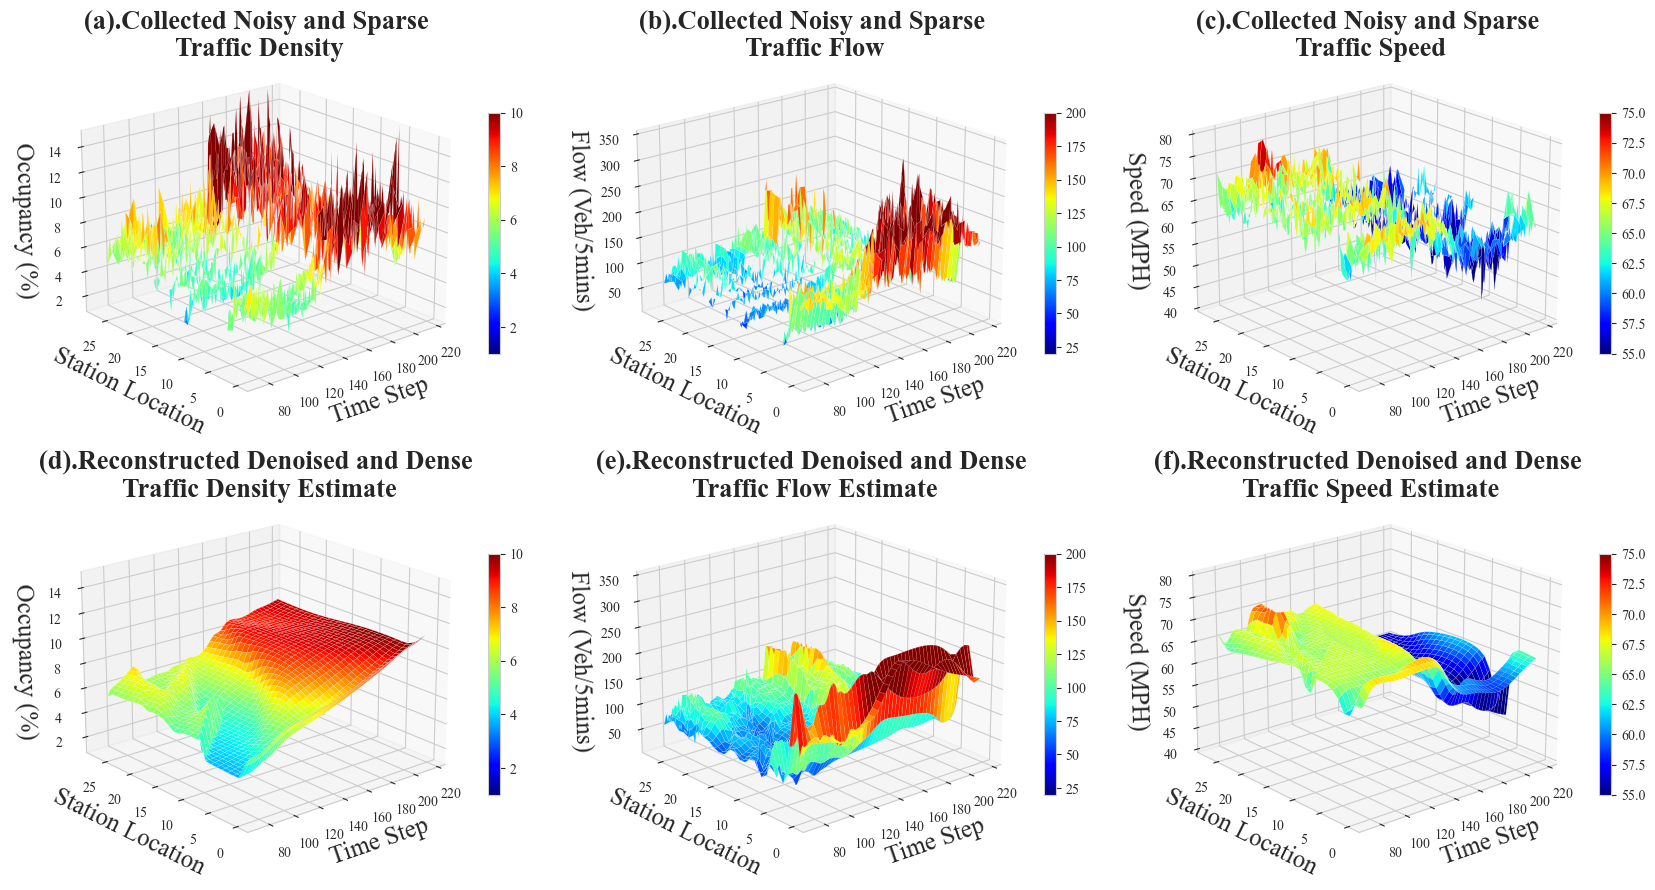

In [12]:
# All
fig = plt.figure(figsize=(17, 9))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim_occu = 15
low_lim_occu = 1

up_lim_flow = 350
low_lim_flow = 10

up_lim_speed = 80
low_lim_speed = 40

norm_occu = plt.Normalize(1, 10)
norm_flow = plt.Normalize(20, 200)
norm_speed = plt.Normalize(55, 75)

loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T
speed_ori = Speed.values.T

ax1 = fig.add_subplot(231, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_occu)
ax1.set_zlim(low_lim_occu, up_lim_occu)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 18)
ax1.set_ylabel('Station Location', fontsize = 18)
ax1.set_zlabel('Occupancy (%)', fontsize = 18)
ax1.set_title('(a).Collected Noisy and Sparse \nTraffic Density', fontsize = 19, weight='bold', y=1)

ax2 = fig.add_subplot(234, projection='3d')
surf2 = ax2.plot_surface(time, loc, occu_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_occu)
ax2.set_zlim(low_lim_occu, up_lim_occu)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 18)
ax2.set_ylabel('Station Location', fontsize = 18)
ax2.set_zlabel('Occupancy (%)', fontsize = 18)
ax2.set_title('(d).Reconstructed Denoised and Dense \nTraffic Density Estimate', fontsize = 19, weight='bold', y=1)


ax3 = fig.add_subplot(232, projection='3d')
surf3 = ax3.plot_surface(time, loc, flow_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_flow)
ax3.set_zlim(low_lim_flow, up_lim_flow)
ax3.view_init(elev=20, azim=230)
ax3.set_xlabel('Time Step', fontsize = 18)
ax3.set_ylabel('Station Location', fontsize = 18)
ax3.set_zlabel('Flow (Veh/5mins)', fontsize = 18)
ax3.set_title('(b).Collected Noisy and Sparse \nTraffic Flow', fontsize = 19, weight='bold', y=1)

ax4 = fig.add_subplot(235, projection='3d')
surf4 = ax4.plot_surface(time, loc, flow_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_flow)
ax4.set_zlim(low_lim_flow, up_lim_flow)
ax4.view_init(elev=20, azim=230)
ax4.set_xlabel('Time Step', fontsize = 18)
ax4.set_ylabel('Station Location', fontsize = 18)
ax4.set_zlabel('Flow (Veh/5mins)', fontsize = 18)
ax4.set_title('(e).Reconstructed Denoised and Dense \nTraffic Flow Estimate', fontsize = 19, weight='bold', y=1)


ax5 = fig.add_subplot(233, projection='3d')
surf5 = ax5.plot_surface(time, loc, speed_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_speed)
ax5.set_zlim(low_lim_speed, up_lim_speed)
ax5.view_init(elev=20, azim=230)
ax5.set_xlabel('Time Step', fontsize = 18)
ax5.set_ylabel('Station Location', fontsize = 18)
ax5.set_zlabel('Speed (MPH)', fontsize = 18)
ax5.set_title('(c).Collected Noisy and Sparse \nTraffic Speed', fontsize = 19, weight='bold', y=1)

ax6 = fig.add_subplot(236, projection='3d')
surf6 = ax6.plot_surface(time, loc, speed_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_speed)
ax6.set_zlim(low_lim_speed, up_lim_speed)
ax6.view_init(elev=20, azim=230)
ax6.set_xlabel('Time Step', fontsize = 18)
ax6.set_ylabel('Station Location', fontsize = 18)
ax6.set_zlabel('Speed (MPH)', fontsize = 18)
ax6.set_title('(f).Reconstructed Denoised and Dense \nTraffic Speed Estimate', fontsize = 19, weight='bold', y=1)

fig.colorbar(surf1, ax=ax1, shrink=0.6)
fig.colorbar(surf2, ax=ax2, shrink=0.6)
fig.colorbar(surf3, ax=ax3, shrink=0.6)
fig.colorbar(surf4, ax=ax4, shrink=0.6)
fig.colorbar(surf5, ax=ax5, shrink=0.6)
fig.colorbar(surf6, ax=ax6, shrink=0.6)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/Reconstruction/All_3D.png",bbox_inches='tight', dpi = 300)

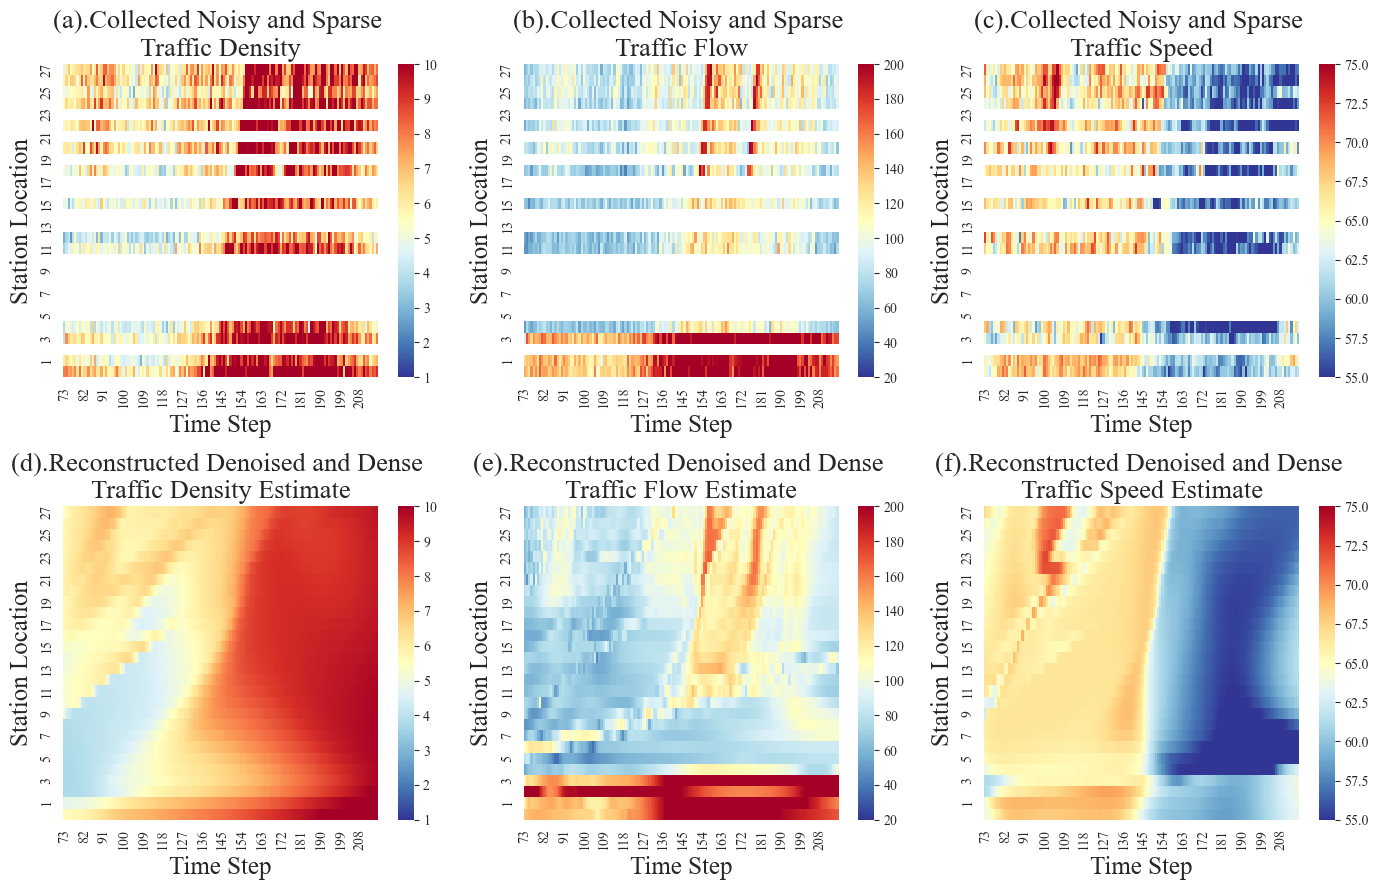

In [13]:
# All
fig = plt.figure(figsize=(14, 9))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim_occu = 15
low_lim_occu = 1

up_lim_flow = 350
low_lim_flow = 10

up_lim_speed = 80
low_lim_speed = 40

norm_occu = plt.Normalize(1, 10)
norm_flow = plt.Normalize(20, 200)
norm_speed = plt.Normalize(55, 75)

loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T
speed_ori = Speed.values.T

vmin1_occu, vmax1_occu = 1, 10

ax1 = fig.add_subplot(231)
sns.heatmap(Occupancy.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax1)
ax1.set_ylabel('Station Location', fontsize = 18)
ax1.set_xlabel('Time Step',  fontsize = 18)
ax1.set_title("(a).Collected Noisy and Sparse \nTraffic Density",  fontsize = 19)

ax2 = fig.add_subplot(234)
sns.heatmap(occupancy_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_occu, vmax=vmax1_occu, annot=False, ax=ax2)
ax2.set_ylabel('Station Location', fontsize = 18)
ax2.set_xlabel('Time Step',  fontsize = 18)
ax2.set_title("(d).Reconstructed Denoised and Dense \nTraffic Density Estimate",  fontsize = 19)

vmin1_flow, vmax1_flow = 20, 200

ax3 = fig.add_subplot(232)
sns.heatmap(Flow.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=ax3)
ax3.set_ylabel('Station Location', fontsize = 18)
ax3.set_xlabel('Time Step',  fontsize = 18)
ax3.set_title("(b).Collected Noisy and Sparse \nTraffic Flow",  fontsize = 19)

ax4 = fig.add_subplot(235)
sns.heatmap(flow_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_flow, vmax=vmax1_flow, annot=False, ax=ax4)
ax4.set_ylabel('Station Location', fontsize = 18)
ax4.set_xlabel('Time Step',  fontsize = 18)
ax4.set_title("(e).Reconstructed Denoised and Dense \nTraffic Flow Estimate",  fontsize = 19)

vmin1_speed, vmax1_speed = 55, 75

ax5 = fig.add_subplot(233)
sns.heatmap(Speed.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=ax5)
ax5.set_ylabel('Station Location', fontsize = 18)
ax5.set_xlabel('Time Step',  fontsize = 18)
ax5.set_title("(c).Collected Noisy and Sparse \nTraffic Speed",  fontsize = 19)

ax6 = fig.add_subplot(236)
sns.heatmap(speed_recon_wide.iloc[::-1], cmap="RdYlBu_r", vmin=vmin1_speed, vmax=vmax1_speed, annot=False, ax=ax6)
ax6.set_ylabel('Station Location', fontsize = 18)
ax6.set_xlabel('Time Step',  fontsize = 18)
ax6.set_title("(f).Reconstructed Denoised and Dense \nTraffic Speed Estimate",  fontsize = 19)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/Reconstruction/All_2D.png",bbox_inches='tight', dpi = 300)

In [14]:
# Reconstruction RMSE
squared_error = (occu_ori - occu_values) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_occu = np.sqrt(mean_squared_error)
rmse_occu

1.929855102423437

In [15]:
squared_error = (flow_ori - flow_values) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_flow = np.sqrt(mean_squared_error)
rmse_flow

17.327275205209347

In [16]:
squared_error = (speed_ori - speed_values) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_speed = np.sqrt(mean_squared_error)
rmse_speed

2.6663181592288505

In [17]:
# Reconstruction MAPE
APE = np.abs((occu_ori - occu_values) / occu_ori)
mape_occu = np.nanmean(APE)
mape_occu

0.19928627846419655

In [18]:
APE = np.abs((flow_ori - flow_values) / flow_ori)
mape_flow = np.nanmean(APE)
mape_flow

0.11406863571980688

In [19]:
APE = np.abs((speed_ori - speed_values) / speed_ori)
mape_speed = np.nanmean(APE)
mape_speed

0.03322143033842587

In [20]:
k_t['TimeStep'] = k_t['TimeStep'].astype(int)
k_t['Station_Number'] = k_t['Station_Number'].astype(int)

k_t_predict['TimeStep'] = k_t_predict['TimeStep'].astype(int)
k_t_predict['Station_Number'] = k_t_predict['Station_Number'].astype(int)

k_t_wide = k_t.pivot(index='Station_Number', columns='TimeStep', values='k_t')
k_t_predict_wide = k_t_predict.pivot(index='Station_Number', columns='TimeStep', values='k_t')

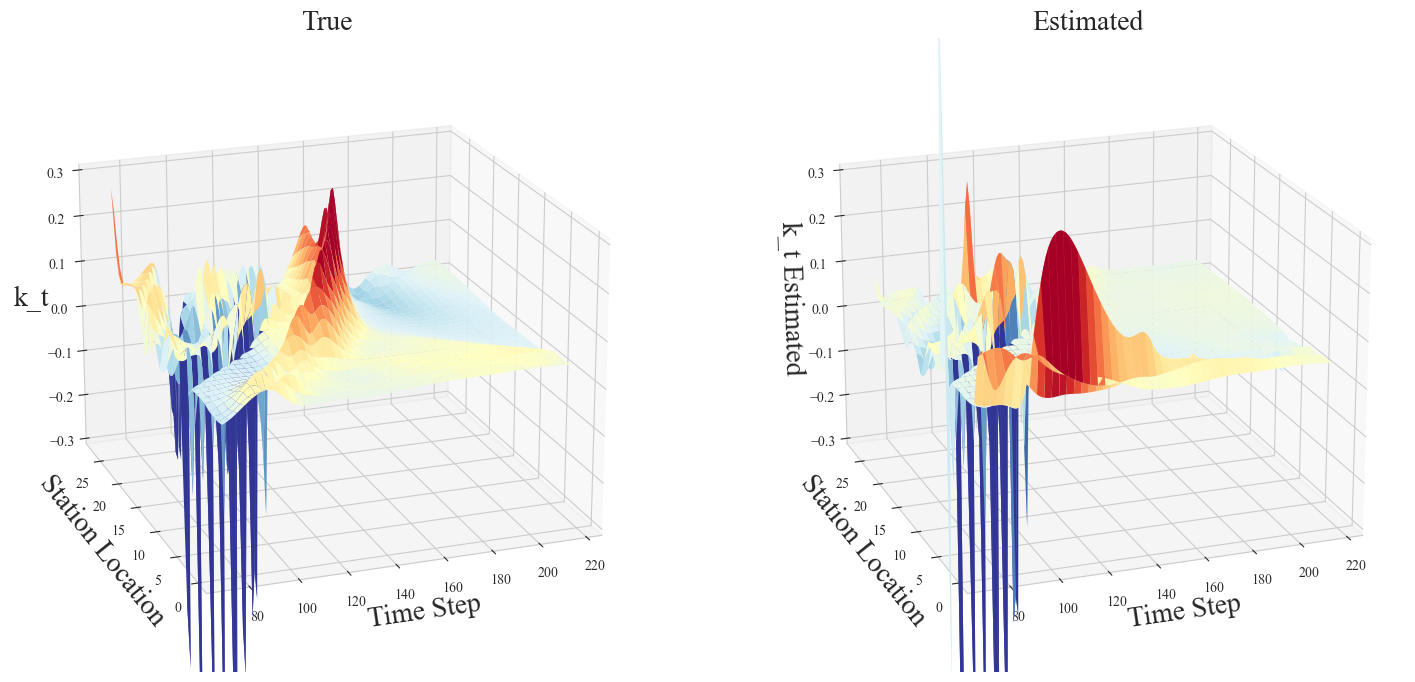

In [21]:
fig = plt.figure(figsize=(18, 9))
plt.rcParams['font.family'] = 'Times New Roman'

loc, time = k_t_wide.index.values, k_t_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
kt_values = k_t_wide.values.T
kt_predict_values = k_t_predict_wide.values.T

# ax1 = fig.add_subplot(131, projection='3d')
#
# surf2 = ax1.plot_surface(time, loc, kt_predict_values, cmap=cm.coolwarm,linewidth=0.02, alpha = 0.7, antialiased=True)
# surf1 = ax1.plot_surface(time, loc, kt_values, cmap='RdBu_r', linewidth=0.02, alpha = 0.7, antialiased=True)
# ax1.view_init(elev=20, azim=150)
# ax1.set_xlabel('Time Step', fontsize = 20)
# ax1.set_ylabel('Station Location', fontsize = 20)
# ax1.set_zlabel('k_t', fontsize = 20)
# ax1.set_zlim(-0.6, 0.6)
# ax1.set_title('Estimated vs True', fontsize = 20)


# loc, time = k_t_predict_wide.index.values, k_t_predict_wide.columns.astype(int).values
# loc, time = np.meshgrid(loc, time)
# kt_predict_values = k_t_predict_wide.values.T

up_lim = 0.2
low_lim = -0.1
norm = plt.Normalize(low_lim, up_lim)

ax2 = fig.add_subplot(121, projection='3d')
surf3 = ax2.plot_surface(time, loc, kt_values, cmap='RdYlBu_r', linewidth=0.02, antialiased=True, norm = norm)

ax2.view_init(elev=20, azim=250)
ax2.set_xlabel('Time Step', fontsize = 20)
ax2.set_ylabel('Station Location', fontsize = 20)
ax2.set_zlabel('k_t', fontsize = 20)
ax2.set_title('True', fontsize = 20)
ax2.set_zlim(-0.3, 0.3)

ax3 = fig.add_subplot(122, projection='3d')
surf4 = ax3.plot_surface(time, loc, kt_predict_values, cmap='RdYlBu_r', linewidth=0.02, antialiased=True, norm = norm)

ax3.view_init(elev=20, azim=250)
ax3.set_xlabel('Time Step', fontsize = 20)
ax3.set_ylabel('Station Location', fontsize = 20)
ax3.set_zlabel('k_t Estimated', fontsize = 20)
ax3.set_title('Estimated', fontsize = 20)
ax3.set_zlim(-0.3, 0.3)
#plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/k_t_3D.png", dpi = 300)

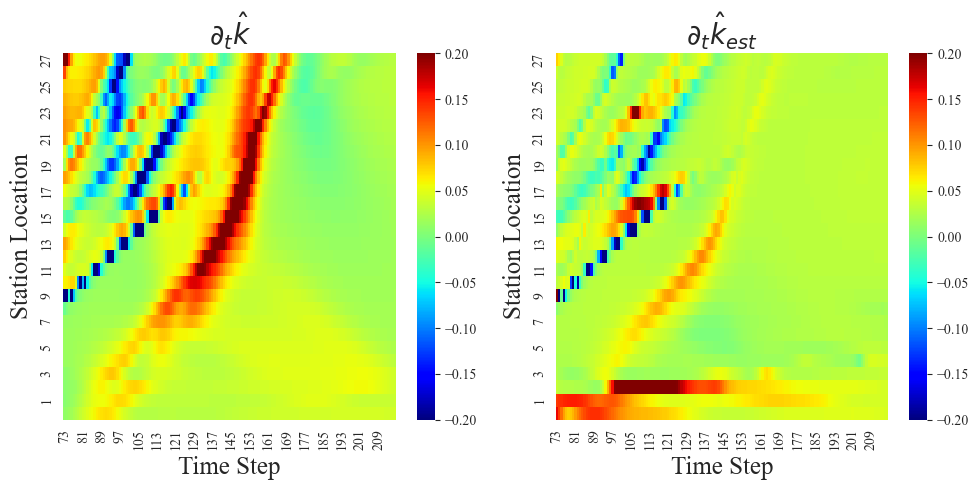

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

vmin, vmax = -0.2, 0.2
sns.heatmap(k_t_wide.iloc[::-1], cmap='jet', vmin=vmin, vmax=vmax, annot=False, robust=True, ax=axs[0])
axs[0].set_ylabel('Station Location',  fontsize = 18)
axs[0].set_xlabel('Time Step',  fontsize = 18)
axs[0].set_title(r'$\partial_t \hat{k}$',  fontsize = 20)

sns.heatmap(k_t_predict_wide.iloc[::-1], cmap='jet', vmin=vmin, vmax=vmax, annot=False,robust=True, ax=axs[1])
axs[1].set_ylabel('Station Location',  fontsize = 18)
axs[1].set_xlabel('Time Step',  fontsize = 18)
axs[1].set_title(r'$\partial_t \hat{k}_{est}$ ',  fontsize = 20)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()

fig.savefig("Figures_first_order/k_dev.png", dpi = 300)

In [23]:
squared_error = (k_t_wide.iloc[::-1] - k_t_predict_wide.iloc[::-1]) ** 2
mean_squared_error = np.nanmean(squared_error)
rmse_occu = np.sqrt(mean_squared_error)
rmse_occu

0.05687937

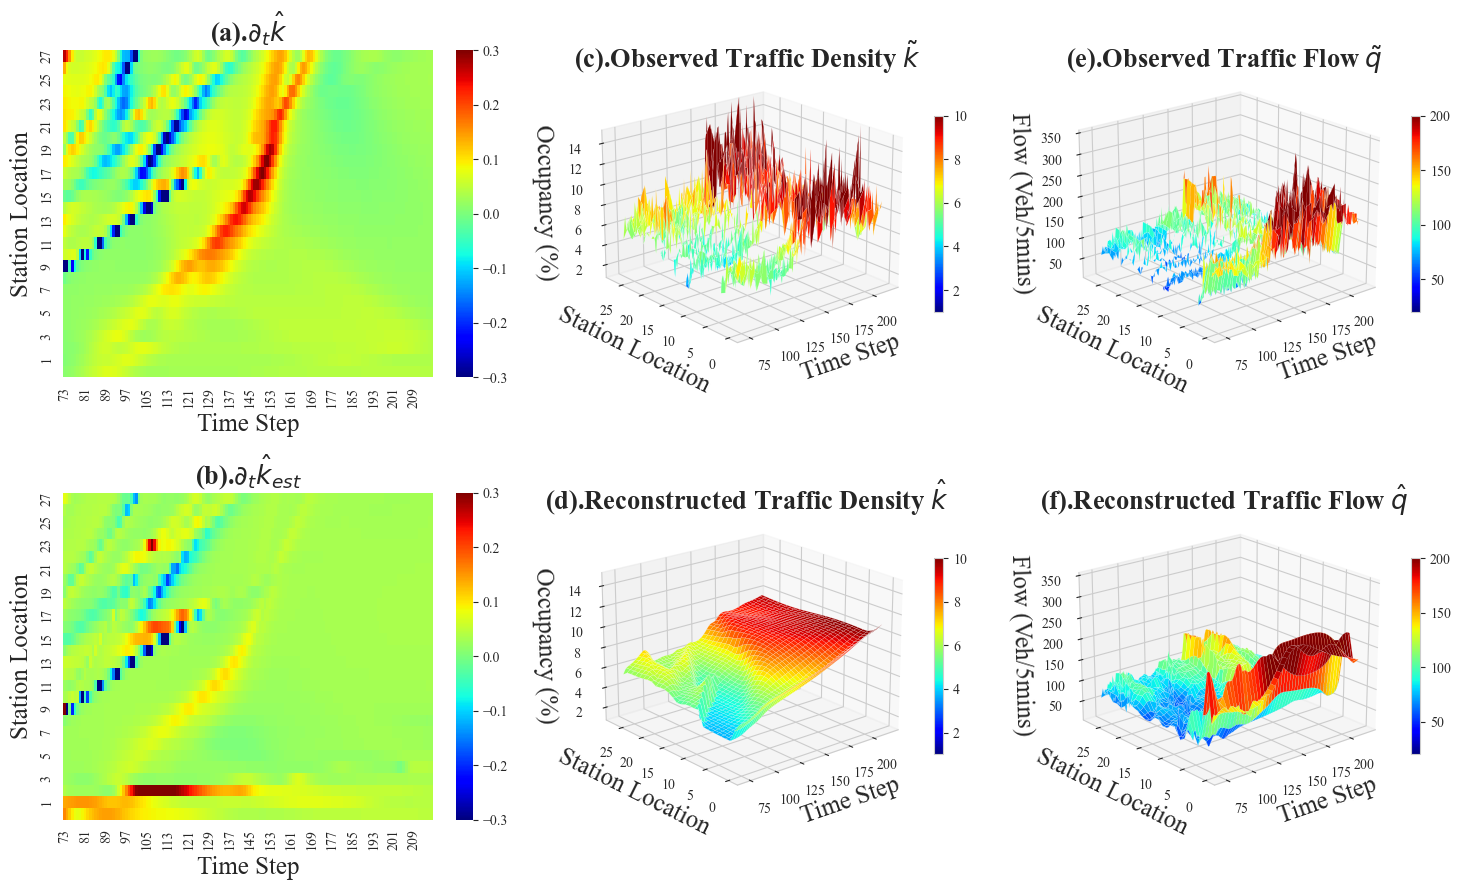

In [24]:

fig = plt.figure(figsize=(15, 9))
plt.rcParams['font.family'] = 'Times New Roman'

up_lim_occu = 15
low_lim_occu = 1

up_lim_flow = 350
low_lim_flow = 10

up_lim_speed = 80
low_lim_speed = 40

norm_occu = plt.Normalize(1, 10)
norm_flow = plt.Normalize(20, 200)
norm_speed = plt.Normalize(55, 75)


loc, time = speed_recon_wide.index.values, speed_recon_wide.columns.astype(int).values
loc, time = np.meshgrid(loc, time)
speed_values = speed_recon_wide.values.T
speed_ori = Speed.values.T

ax3 = fig.add_subplot(231)
vmin, vmax = -0.3, 0.3
sns.heatmap(k_t_wide.iloc[::-1], cmap='jet', vmin=vmin, vmax=vmax, annot=False, robust=True, ax=ax3)
ax3.set_ylabel('Station Location',  fontsize = 18)
ax3.set_xlabel('Time Step',  fontsize = 18)
ax3.set_title(r'(a).$\partial_t \hat{k}$',  fontsize = 19, weight='bold')

ax4 = fig.add_subplot(234)
sns.heatmap(k_t_predict_wide.iloc[::-1], cmap='jet', vmin=vmin, vmax=vmax, annot=False,robust=True, ax=ax4)
ax4.set_ylabel('Station Location',  fontsize = 18)
ax4.set_xlabel('Time Step',  fontsize = 18)
ax4.set_title(r'(b).$\partial_t \hat{k}_{est}$ ',  fontsize = 19, weight='bold')

ax1 = fig.add_subplot(232, projection='3d')
surf1 = ax1.plot_surface(time, loc, occu_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_occu)
ax1.set_zlim(low_lim_occu, up_lim_occu)
ax1.view_init(elev=20, azim=230)
ax1.set_xlabel('Time Step', fontsize = 18)
ax1.set_ylabel('Station Location', fontsize = 18)
ax1.set_zlabel('Occupancy (%)', fontsize = 18)
ax1.set_title(r'(c).Observed Traffic Density $\tilde{k}$', fontsize = 19, weight='bold', y=1)

ax2 = fig.add_subplot(235, projection='3d')
surf2 = ax2.plot_surface(time, loc, occu_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_occu)
ax2.set_zlim(low_lim_occu, up_lim_occu)
ax2.view_init(elev=20, azim=230)
ax2.set_xlabel('Time Step', fontsize = 18)
ax2.set_ylabel('Station Location', fontsize = 18)
ax2.set_zlabel('Occupancy (%)', fontsize = 18)
ax2.set_title('(d).Reconstructed Traffic Density $\hat{k}$', fontsize = 19, weight='bold', y=1)

ax5 = fig.add_subplot(233, projection='3d')
surf5 = ax5.plot_surface(time, loc, flow_ori, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_flow)
ax5.set_zlim(low_lim_flow, up_lim_flow)
ax5.view_init(elev=20, azim=230)
ax5.set_xlabel('Time Step', fontsize = 18)
ax5.set_ylabel('Station Location', fontsize = 18)
ax5.set_zlabel('Flow (Veh/5mins)', fontsize = 18)
ax5.set_title(r'(e).Observed Traffic Flow $\tilde{q}$', fontsize = 19, weight='bold', y=1)

ax6 = fig.add_subplot(236, projection='3d')
surf6 = ax6.plot_surface(time, loc, flow_values, cmap='jet',linewidth=0.1, alpha = 1, antialiased=True, norm=norm_flow)
ax6.set_zlim(low_lim_flow, up_lim_flow)
ax6.view_init(elev=20, azim=230)
ax6.set_xlabel('Time Step', fontsize = 18)
ax6.set_ylabel('Station Location', fontsize = 18)
ax6.set_zlabel('Flow (Veh/5mins)', fontsize = 18)
ax6.set_title(r'(f).Reconstructed Traffic Flow $\hat{q}$', fontsize = 19, weight='bold', y=1)

fig.colorbar(surf1, ax=ax1, shrink=0.6)
fig.colorbar(surf2, ax=ax2, shrink=0.6)
fig.colorbar(surf5, ax=ax5, shrink=0.6)
fig.colorbar(surf6, ax=ax6, shrink=0.6)

plt.rcParams['font.family'] = 'Times New Roman'
plt.tight_layout()
plt.show()
fig.savefig("Figures_first_order/First_Order_Result.png",bbox_inches='tight', dpi = 300)